In [127]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from mizani.formatters import percent_format
from plotnine import *
from datetime import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from IPython.core.display import HTML
from stargazer.stargazer import Stargazer
import statsmodels.nonparametric.kernel_regression as loess
from skimpy import skim
import wbdata
from linearmodels import PanelOLS


warnings.filterwarnings("ignore")

### <span style="color:blue"><b>1. Data cleaning</b></span>

#### Data importing

Government expenditure, percent of GDP, is sourced from IMF: https://www.imf.org/external/datamapper/exp@FPP/USA/FRA/JPN/GBR/SWE/ESP/ITA/ZAF/IND 

In [128]:
data_imf = pd.read_csv("https://raw.githubusercontent.com/Enkhsaikhan-u/Crowding-out/refs/heads/main/imf-dm-export-20250223.csv")

In [129]:
data_imf

,"Government expenditure, percent of GDP (% of GDP)",1800,1801,1802,1803,1804,1805,1806,1807,1808,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Albania,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,29.192714,31.729155,30.757805,29.139476,29.161570,29.076871,29.075409,32.552481,32.118680,30.444901
1,Algeria,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,36.648827,41.290308,46.221667,41.995341,41.119140,40.320911,41.785973,42.428476,37.077163,37.049551
2,Angola,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,37.049582,36.456765,27.051105,22.043143,24.102783,20.578761,20.402984,23.276727,19.476577,22.543400
3,Antigua and Barbuda,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,23.222913,23.009869,26.704125,24.657828,23.577386,22.300603,22.782688,25.890662,24.009335,23.884725
4,Argentina,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,37.602933,38.852931,41.366330,41.522021,41.121454,38.949208,37.702665,42.059376,37.779438,37.275068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,Vietnam,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,24.457023,22.754928,24.173594,22.230677,21.529306,20.479760,19.811254,21.251144,20.143339,18.774073
150,Yemen,no data,no data,no data,no data,no data,no data,no data,no data,no data,...,30.797300,27.780078,19.430181,16.068330,8.392471,14.264085,13.207490,10.641834,8.217839,12.172452
151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Historical classification by income is taked from: https://datatopics.worldbank.org/world-development-indicators/the-world-by-income-and-region.html 

In [130]:
data_income = pd.read_csv("https://raw.githubusercontent.com/Enkhsaikhan-u/Crowding-out/refs/heads/main/OGHIST.csv")

In [131]:
data_income

,Unnamed: 0,Unnamed: 1,1987,1988,1989,1990,1991,1992,1993,1994,...,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023
0,AFG,Afghanistan,L,L,L,L,L,L,L,L,...,L,L,L,L,L,L,L,L,L,L
1,ALB,Albania,..,..,..,LM,LM,LM,L,L,...,UM,UM,UM,UM,UM,UM,UM,UM,UM,UM
2,DZA,Algeria,UM,UM,LM,LM,LM,LM,LM,LM,...,UM,UM,UM,UM,UM,LM,LM,LM,LM,UM
3,ASM,American Samoa,H,H,H,UM,UM,UM,UM,UM,...,UM,UM,UM,UM,UM,UM,UM,UM,H,H
4,AND,Andorra,..,..,..,H,H,H,H,H,...,H,H,H,H,H,H,H,H,H,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,YUG,Serbia and Montenegro (former),..,..,..,..,..,LM,LM,LM,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
235,SUN,USSR (former),..,..,..,UM,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,YUGf,Yugoslavia (former),UM,UM,UM,UM,UM,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
wbdata.get_indicators(source=2)

id                          name
--------------------------  ---------------------------------------------------------------------------------------------------------------------------------------------
AG.CON.FERT.PT.ZS           Fertilizer consumption (% of fertilizer production)
AG.CON.FERT.ZS              Fertilizer consumption (kilograms per hectare of arable land)
AG.LND.AGRI.K2              Agricultural land (sq. km)
AG.LND.AGRI.ZS              Agricultural land (% of land area)
AG.LND.ARBL.HA              Arable land (hectares)
AG.LND.ARBL.HA.PC           Arable land (hectares per person)
AG.LND.ARBL.ZS              Arable land (% of land area)
AG.LND.CREL.HA              Land under cereal production (hectares)
AG.LND.CROP.ZS              Permanent cropland (% of land area)
AG.LND.EL5M.RU.K2           Rural land area where elevation is below 5 meters (sq. km)
AG.LND.EL5M.RU.ZS           Rural land area where elevation is below 5 meters (% of total land area)
AG.LND.EL5M.UR.K2  

Private investment (% of GDP), GDP growth, Trade (% of GDP), and inflation are sourced from The World Bank API. 

In [133]:
indicators = {"NE.TRD.GNFS.ZS":"openness", "NY.GDP.MKTP.KD.ZG":"growth", "FP.CPI.TOTL.ZG":"inf",
              "NE.GDI.FTOT.ZS":"inv_share", "NE.CON.GOVT.KD.ZG":"gov_cons", "PA.NUS.FCRF":"exch",
              "FR.INR.RINR":"rint"}

data_wb = wbdata.get_dataframe(indicators, country = "all", parse_dates = True)

In [134]:
data_wb

openness    growth        inf  \
country                     date                                         
Africa Eastern and Southern 2023-01-01  56.872392  2.320138   7.126975   
                            2022-01-01  58.536163  3.553878  10.773751   
                            2021-01-01  55.562396  4.576393   7.240978   
                            2020-01-01  50.265326 -2.864293   5.405162   
                            2019-01-01  52.460690  2.194319   4.653665   
...                                           ...       ...        ...   
Zimbabwe                    1964-01-01        NaN -1.106172        NaN   
                            1963-01-01        NaN  6.244345        NaN   
                            1962-01-01        NaN  1.434471        NaN   
                            1961-01-01        NaN  6.316157        NaN   
                            1960-01-01        NaN       NaN        NaN   

                                        inv_share  gov_cons      exch  rint  
country                     date                                             
Africa Eastern and Southern 2023-01-01  19.518419 -2.330086       NaN   NaN  
                            2022-01-01  20.356012  3.802356       NaN   NaN  
                            2021-01-01  19.926013  3.969668       NaN   NaN  
                            2020-01-01  20.477316 -0.179344       NaN   NaN  
                            2019-01-01  21.058907  2.184870       NaN   NaN  
...                                           ...       ...       ...   ...  
Zimbabwe                    1964-01-01  11.339980       NaN  0.000714   NaN  
                            1963-01-01  12.734050       NaN  0.000714   NaN  
                            1962-01-01  14.073199       NaN  0.000714   NaN  
                            1961-01-01  18.439860       NaN  0.000714   NaN  
                            1960-01-01  20.271267       NaN  0.000714   NaN  

[17024 rows x 7 columns]

#### Data cleaning and merging

Converting wide formats into long formats

In [135]:
data_imf = data_imf.melt(id_vars=["Government expenditure, percent of GDP (% of GDP)"], 
                                  var_name="year", 
                                  value_name="gov_exp")

In [136]:
data_imf = data_imf.rename(columns={"Government expenditure, percent of GDP (% of GDP)":"country"})

In [137]:
data_imf

,country,year,gov_exp
0,Albania,1800,no data
1,Algeria,1800,no data
2,Angola,1800,no data
3,Antigua and Barbuda,1800,no data
4,Argentina,1800,no data
...,...,...,...
34337,Vietnam,2022,18.774073
34338,Yemen,2022,12.172452
34339,NaN,2022,NaN
34340,NaN,2022,NaN


In [138]:
data_imf = data_imf[data_imf["year"]>="1990"]
data_imf = data_imf[data_imf["country"] != "©IMF, 2024"]

In [139]:
data_imf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5049 entries, 29260 to 34340
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   country  4983 non-null   object
 1   year     5049 non-null   object
 2   gov_exp  4983 non-null   object
dtypes: object(3)
memory usage: 157.8+ KB


In [140]:
data_imf["gov_exp"] = data_imf["gov_exp"].replace("no data", np.nan)
data_imf["gov_exp"] = pd.to_numeric(data_imf["gov_exp"], errors ="coerce")
data_imf["year"] = pd.to_numeric(data_imf["year"], errors="coerce").astype("Int64")

In [141]:
data_imf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5049 entries, 29260 to 34340
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   country  4983 non-null   object 
 1   year     5049 non-null   Int64  
 2   gov_exp  4712 non-null   float64
dtypes: Int64(1), float64(1), object(1)
memory usage: 162.7+ KB


In [142]:
# Mapping of country names from the first dataset to match the second dataset
country_mapping = {
    "Czech Republic": "Czechia",
    "Türkiye, Republic of": "Turkiye",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Korea, Republic of": "Korea, Rep.",
    "Micronesia, Fed. States of": "Micronesia, Fed. Sts.",
    "Vietnam": "Viet Nam",
    "Iran": "Iran, Islamic Rep.",
    "Yemen": "Yemen, Rep.",
    "Venezuela": "Venezuela, RB",
    "Hong Kong SAR": "Hong Kong SAR, China",
    "Congo, Dem. Rep. of the": "Congo, Dem. Rep.",
    "Congo, Republic of ": "Congo, Rep.",
    "North Macedonia ": "North Macedonia",  # Remove extra space
    "Saint Kitts and Nevis": "St. Kitts and Nevis",
    "Saint Lucia": "St. Lucia",
    "Saint Vincent and the Grenadines": "St. Vincent and the Grenadines",
    "China, People's Republic of": "China"
}

# Assume df is your DataFrame containing the first dataset
data_imf['country'] = data_imf['country'].replace(country_mapping)

In [143]:
data_income = data_income.rename(columns={"Unnamed: 0": "code", "Unnamed: 1": "country"})
data_income = data_income.melt(id_vars=["code", "country"],
                               var_name = "year",
                               value_name= "income_cat")
data_income["year"] = data_income["year"].astype(int)


In [144]:
data_income["income_cat"] = data_income["income_cat"].replace("..", np.nan)

In [145]:
data_income = data_income.dropna(subset=["code", "country"])

In [146]:
data_income = data_income[~data_income["year"].isin([1987, 1988, 1989, 2023])]

In [147]:
data_income

,code,country,year,income_cat
717,AFG,Afghanistan,1990,L
718,ALB,Albania,1990,LM
719,DZA,Algeria,1990,LM
720,ASM,American Samoa,1990,UM
721,AND,Andorra,1990,H
...,...,...,...,...
8597,MYT,Mayotte,2022,NaN
8598,ANT,Netherlands Antilles (former),2022,NaN
8599,YUG,Serbia and Montenegro (former),2022,NaN
8600,SUN,USSR (former),2022,NaN


In [148]:
data_wb = data_wb.reset_index()

In [149]:
data_wb["year"] = data_wb["date"].dt.year

In [150]:
dropping = {'Africa Eastern and Southern', 'Africa Western and Central',
       'Arab World', 'Caribbean small states',
       'Central Europe and the Baltics', 'Early-demographic dividend',
       'East Asia & Pacific',
       'East Asia & Pacific (excluding high income)',
       'East Asia & Pacific (IDA & IBRD countries)', 'Euro area',
       'Europe & Central Asia',
       'Europe & Central Asia (excluding high income)',
       'Europe & Central Asia (IDA & IBRD countries)', 'European Union',
       'Fragile and conflict affected situations',
       'Heavily indebted poor countries (HIPC)', 'High income',
       'IBRD only', 'IDA & IBRD total', 'IDA blend', 'IDA only',
       'IDA total', 'Late-demographic dividend',
       'Latin America & Caribbean',
       'Latin America & Caribbean (excluding high income)',
       'Latin America & the Caribbean (IDA & IBRD countries)',
       'Least developed countries: UN classification',
       'Low & middle income', 'Low income', 'Lower middle income',
       'Middle East & North Africa',
       'Middle East & North Africa (excluding high income)',
       'Middle East & North Africa (IDA & IBRD countries)',
       'Middle income', 'North America', 'Not classified', 'OECD members',
       'Other small states', 'Pacific island small states',
       'Post-demographic dividend', 'Pre-demographic dividend',
       'Small states', 'South Asia', 'South Asia (IDA & IBRD)',
       'Sub-Saharan Africa', 'Sub-Saharan Africa (excluding high income)',
       'Sub-Saharan Africa (IDA & IBRD countries)', 'Upper middle income',
       'World' }

data_wb_country = data_wb[~data_wb["country"].isin(dropping)]

In [151]:
data_wb_country = data_wb_country[(data_wb_country["year"] >= 1990) & (data_wb_country["year"] <= 2022)]

In [152]:
data_wb_country.country.nunique()

217

Merging data sets

In [153]:
d1 = data_imf["country"].nunique()
d2 = data_income["country"].nunique()
d3 = data_wb_country["country"].nunique()

print(d1)
print(d2)
print(d3)

151
224
217


In [154]:
data_merged = pd.merge(data_imf, data_wb_country, on=["country", "year"], how='left', indicator = True)

In [155]:
data_merged = pd.merge(data_merged, data_income, on=["country", "year"], how='left')

In [156]:
data_merged.isna().sum()

country         66
year             0
gov_exp        337
date            66
openness       678
growth         115
inf            480
inv_share      918
gov_cons      1306
exch           157
rint          1953
_merge           0
code           132
income_cat     159
dtype: int64

In [157]:
data_panel = data_merged.dropna(subset=["gov_exp", "inv_share"])

Balancing panel data

In [158]:
data_merged

,country,year,gov_exp,date,openness,growth,inf,inv_share,gov_cons,exch,rint,_merge,code,income_cat
0,Albania,1990,NaN,1990-01-01,39.436963,-9.575640,NaN,30.360947,NaN,NaN,1.437570,both,ALB,LM
1,Algeria,1990,25.259740,1990-01-01,48.380714,0.800001,16.652534,26.970133,1.500002,8.957508e+00,NaN,both,DZA,LM
2,Angola,1990,NaN,1990-01-01,NaN,-3.450099,NaN,0.000000,NaN,2.991800e-08,NaN,both,AGO,LM
3,Antigua and Barbuda,1990,18.887205,1990-01-01,NaN,3.011319,NaN,NaN,NaN,2.700000e+00,8.366036,both,ATG,UM
4,Argentina,1990,10.990300,1990-01-01,14.990859,-2.467214,NaN,13.996982,NaN,4.875891e-01,NaN,both,ARG,LM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5044,"Venezuela, RB",2022,11.986835,2022-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,both,VEN,NaN
5045,Viet Nam,2022,18.774073,2022-01-01,183.789541,8.123514,3.156507,30.784994,3.620000,2.327121e+04,3.807827,both,VNM,LM
5046,"Yemen, Rep.",2022,12.172452,2022-01-01,NaN,NaN,NaN,NaN,NaN,1.115002e+03,NaN,both,YEM,L
5047,NaN,2022,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,NaN,NaN


In [159]:
data_panel = data_panel[(data_panel["year"] >= 1990) & data_panel["year"] <=2022]

In [160]:
data_panel["balanced"] = data_panel["country"].isin(
   data_panel.groupby("country")
    .agg(
        min_year=("year", min), max_year=("year", max), n_unique_years=("year", "count")
    )
    .query("(min_year == 1990)&(max_year == 2022)&(n_unique_years==33)")
    .index
)

In [161]:
data_panel.balanced.value_counts()

balanced
True     2277
False    1673
Name: count, dtype: int64

In [162]:
data_panel["lexch"] = np.log(data_panel["exch"])

In [163]:
data_panel["country"].nunique()

136

In [164]:
data_panel_2022 = data_panel[data_panel["year"] == 2022]
data_panel_2022["income_cat"].value_counts()

income_cat
H     45
LM    36
UM    31
L     13
Name: count, dtype: int64

### <span style="color:blue"><b>2. Descriptive statistics and charts</b></span>

In [165]:
display(data_panel[["inv_share", "gov_exp", "growth","openness", "inf", "exch"]].describe().T)

,count,mean,std,min,25%,50%,75%,max
inv_share,3950.0,22.721674,7.261653,1.225171,18.483916,21.992228,25.834886,78.000917
gov_exp,3950.0,30.852860,13.944339,2.147378,19.714136,29.194500,40.052417,204.170136
growth,3948.0,3.440678,4.829975,-50.248067,1.538609,3.673323,5.772938,82.809329
openness,3928.0,81.400580,49.469437,2.698834,49.346809,70.464295,100.183717,442.620019
inf,3740.0,10.930110,128.578816,-16.859691,1.783110,3.657058,7.865687,7481.663611
exch,3924.0,625.771041,2672.408666,0.002609,1.484922,9.944486,233.603333,42000.000000


In [166]:
gov_exp = data_merged.groupby(["income_cat", "year"])[["gov_exp", "inv_share"]].mean().reset_index()
gov_exp = gov_exp[gov_exp["year"] >= 1995]

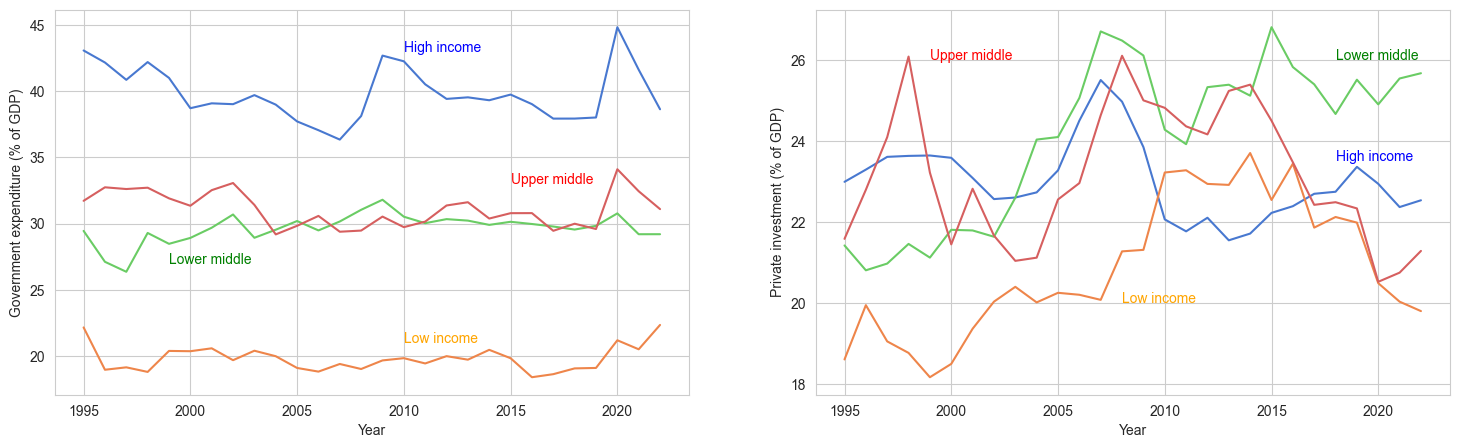

<Figure size 900x500 with 0 Axes>

In [167]:
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

sns.set_palette("muted")
sns.set_style("whitegrid")

plt.figure(figsize=(9, 5))
sns.lineplot(ax=axes[0], data=gov_exp, x='year', y='gov_exp', hue='income_cat')
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Government expenditure (% of GDP)")

axes[0].text(2010, 21, "Low income", color = "Orange")
axes[0].text(1999, 27, "Lower middle", color = "green")
axes[0].text(2015, 33, "Upper middle", color = "red")
axes[0].text(2010, 43, "High income", color = "blue")

axes[0].legend([], [], frameon=False)

sns.lineplot(ax=axes[1], data=gov_exp, x='year', y='inv_share', hue='income_cat')
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Private investment (% of GDP)")

axes[1].text(2008, 20, "Low income", color = "Orange")
axes[1].text(2018, 26, "Lower middle", color = "green")
axes[1].text(1999, 26, "Upper middle", color = "red")
axes[1].text(2018, 23.5, "High income", color = "blue")

axes[1].legend([], [], frameon=False)

Text(0, 0.5, 'Private investment (% of GDP)')

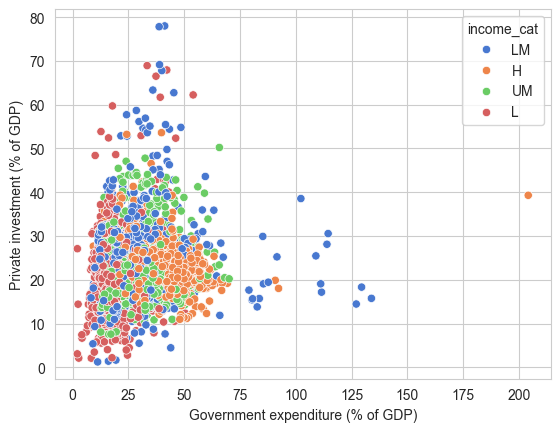

In [168]:
sns.scatterplot(data=data_panel, x="gov_exp", y="inv_share", hue="income_cat")
plt.xlabel("Government expenditure (% of GDP)")
plt.ylabel("Private investment (% of GDP)")

Heatmap

In [169]:
data_panel["gov_exp"] = pd.to_numeric(data_panel["gov_exp"], errors="coerce")

In [170]:
heatmap_data = data_panel.pivot(index="country", columns="year", values="gov_exp")
heatmap_data = heatmap_data.fillna(0) 

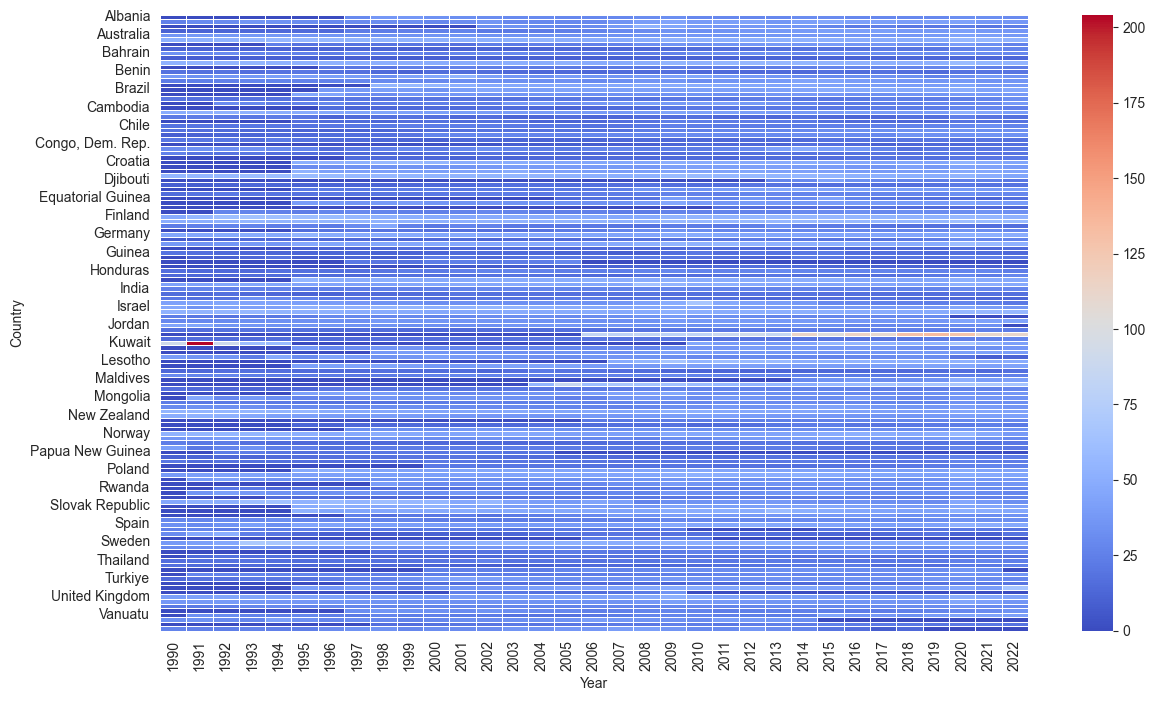

In [171]:
# Adjust figure size for better readability
plt.figure(figsize=(14, 8))
sns.heatmap(heatmap_data, cmap="coolwarm", linewidths=0.5)
plt.xlabel("Year")
plt.ylabel("Country")
plt.show()

### <span style="color:blue"><b>3. Fixed effect regression</b></span>

In [172]:
data_panel = data_panel.assign(
    Year=lambda x: x["year"].astype("category")
).set_index(["country", "year"])

In [173]:
fe_1 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + TimeEffects + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)


In [174]:
fe_1

Dep. Variable:,inv_share,R-squared:,0.0232
Estimator:,PanelOLS,R-squared (Between):,0.3302
No. Observations:,3950,R-squared (Within):,0.0274
Date:,"Fri, Feb 28 2025",R-squared (Overall):,0.3202
Time:,14:07:21,Log-likelihood,-1.191e+04
Cov. Estimator:,Clustered,,
,,F-statistic:,89.639
Entities:,136,P-value,0.0000
Avg Obs:,29.044,Distribution:,"F(1,3781)"
Min Obs:,5.0000,,
Max Obs:,33.000,F-statistic (robust):,12.673


In [175]:
fe_2 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + Year + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)


In [176]:
fe_3 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + Year + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)


In [177]:
table = Stargazer([fe_1, fe_2, fe_3])
table.covariate_order(
    [
        "gov_exp",
        "growth",
        "openness",
        "inf",
        "lexch" 
    ]
)
table.rename_covariates({"Intercept": "Constant"})
table.add_line("Year fixed effect", ["Yes", "Yes", "Yes"])
table.add_line("Country fixed effect", ["Yes", "Yes", "Yes"])
table



### Developed vs Developing

In [178]:
data_panel_high = data_panel[data_panel["income_cat"] == "H"]
data_panel_low = data_panel[data_panel["income_cat"] != "H"]

In [179]:
data1 = data_panel_high.reset_index()
data2 = data_panel_low.reset_index()

In [180]:
data1["country"].nunique()

51

In [181]:
data2["country"].nunique()

109

In [182]:
fe_high = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + Year + EntityEffects",
    data_panel_high
).fit(cov_type="clustered", cluster_entity=True)

In [183]:
fe_low = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + Year + EntityEffects",
    data_panel_low
).fit(cov_type="clustered", cluster_entity=True)

In [184]:
table_all = Stargazer([fe_1, fe_2, fe_3, fe_high, fe_low])
table_all.custom_columns(["(1)", "(2)", "(3)", "Developed countries", "Developing countries"], [1, 1, 1, 1, 1])
table_all.covariate_order(
    [
        "gov_exp",
        "growth",
        "openness",
        "inf",
        "lexch" 
    ]
)
table_all.rename_covariates({"Intercept": "Constant"})
table_all.add_line("Year fixed effect", ["Yes", "Yes", "Yes", "Yes", "Yes"])
table_all.add_line("Country fixed effect", ["Yes", "Yes", "Yes", "Yes", "Yes"])
table_all

## Rolling window

In [185]:
# Split the data by period without resetting index
data_1990_1999 = data_panel.loc[(data_panel.index.get_level_values("year") >= 1990) & 
                                (data_panel.index.get_level_values("year") <= 1999)]

data_2000_2009 = data_panel.loc[(data_panel.index.get_level_values("year") >= 2000) & 
                                (data_panel.index.get_level_values("year") <= 2009)]

data_2010_2022 = data_panel.loc[(data_panel.index.get_level_values("year") >= 2010) & 
                                (data_panel.index.get_level_values("year") <= 2022)]

In [186]:
corr_matrix = data_1990_1999[['gov_exp', 'growth', 'openness', 'inf', 'exch', 'Year']].corr()
print(corr_matrix)

           gov_exp    growth  openness       inf      exch      Year
gov_exp   1.000000 -0.099025  0.138076 -0.041594 -0.167795 -0.043426
growth   -0.099025  1.000000  0.037453 -0.119470 -0.015191 -0.012363
openness  0.138076  0.037453  1.000000 -0.046435 -0.040934  0.105295
inf      -0.041594 -0.119470 -0.046435  1.000000 -0.011257 -0.068131
exch     -0.167795 -0.015191 -0.040934 -0.011257  1.000000  0.127995
Year     -0.043426 -0.012363  0.105295 -0.068131  0.127995  1.000000


In [187]:
fe_1990_1999 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + TimeEffects + EntityEffects",
    data_1990_1999
).fit(cov_type="clustered", cluster_entity=True)

fe_2000_2009 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + TimeEffects + EntityEffects",
    data_2000_2009
).fit(cov_type="clustered", cluster_entity=True)

fe_2010_2022 = PanelOLS.from_formula(
    "inv_share ~ gov_exp + growth + openness + inf + lexch + TimeEffects + EntityEffects",
    data_2010_2022
).fit(cov_type="clustered", cluster_entity=True)

In [188]:
table_all = Stargazer([fe_1990_1999, fe_2000_2009, fe_2010_2022])
table_all.custom_columns(["1990-1999", "2000_2009", "2010_2022"], [1, 1, 1])
table_all.covariate_order(
    [
        "gov_exp",
        "growth",
        "openness",
        "inf",
        "lexch" 
    ]
)
table_all.rename_covariates({"Intercept": "Constant"})
table_all.add_line("Year fixed effect", ["Yes", "Yes", "Yes"])
table_all.add_line("Country fixed effect", ["Yes", "Yes", "Yes"])
table_all

### Investment vs Interest rate

In [189]:
fe_int_1 = PanelOLS.from_formula(
    "inv_share ~ rint + TimeEffects + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)

fe_int_2 = PanelOLS.from_formula(
    "inv_share ~ rint + growth + openness + TimeEffects + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)

fe_int_3 = PanelOLS.from_formula(
    "inv_share ~ rint + growth + openness + inf + lexch + TimeEffects + EntityEffects",
    data_panel
).fit(cov_type="clustered", cluster_entity=True)

In [192]:
table_int = Stargazer([fe_int_1, fe_int_2, fe_int_3])
table_int.covariate_order(
    [
        "rint",
        "growth",
        "openness",
        "inf",
        "lexch" 
    ]
)
table_int.rename_covariates({"Intercept": "Constant"})
table_int.add_line("Year fixed effect", ["Yes", "Yes", "Yes"])
table_int.add_line("Country fixed effect", ["Yes", "Yes", "Yes"])
table_int